In [1]:
def load_change_events(change_events_file):
    """
    Load the change events from a JSON file.
    """
    if not os.path.exists(change_events_file):
        raise FileNotFoundError(f"{change_events_file} does not exist")
    with open(change_events_file, 'r') as f:
        events = json.load(f)
    return events

def extract_features(events):
    """
    Convert the change events into a feature matrix.
    This example assumes each event contains an "object_id".
    The features include:
      - Basic event info (e.g., delta_t_hours, number_of_points)
      - Change magnitude statistics (mean, std, min, max, median, quant90, quant95, quant99)
      - Convex hull properties (hull surface area, volume, and ratio)
      - Geometric features from both epochs
    """
    rows = []
    for event in events:
        row = {}
        # Basic features
        # row['delta_t_hours'] = event.get('delta_t_hours', np.nan)
        # row['number_of_points'] = event.get('number_of_points', np.nan)
        
        # Change magnitude statistics
        change_mags = event.get('change_magnitudes', {})
        for stat in ['mean', 'std', 'min', 'max', 'median', 'quant90', 'quant95', 'quant99']:
            row[f'change_{stat}'] = change_mags.get(stat, np.nan)
        
        # Convex hull properties
        convex_hull = event.get('convex_hull', {})
        row['hull_surface_area'] = convex_hull.get('surface_area', np.nan)
        row['hull_volume'] = convex_hull.get('volume', np.nan)
        row['hull_surf_vol_ratio'] = convex_hull.get('surface_area_to_volume_ratio', np.nan)
        
        # Geometric features from both epochs (if available)
        geom = event.get('geometric_features_both_epochs', {})
        for feat in ['sum_of_eigenvalues', 'omnivariance', 'eigentropy', 'anisotropy',
                     'planarity', 'linearity', 'surface_variation', 'sphericity', 'verticality']:
            row[f'geom_{feat}'] = geom.get(feat, np.nan)
        
        # Keep the unique identifier
        row['object_id'] = event.get('object_id')
        row["event_type"] = event.get('event_type', np.nan)
        
        rows.append(row)
    df = pd.DataFrame(rows)
    return df


In [ ]:
# Train a random forest model on labeled data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)

# Path to the unlabelled change events test file
labelled_file = "../test_data/change_events_labelled.json" # This file will be used for training
predict_change_events = "../test_data/change_events_unlabelled_for_prediction.json" # This file will be used for prediction
predicted_file = "../test_data/change_events_labelled_by_RF_prediction.json" # This will be created

# Ramdom Forest parameters
n_estimators = 100 # Number of trees in the forest
max_depth=10 # Maximum depth of the tree
min_samples_split=2 # Minimum number of samples required to split an internal node
min_samples_leaf=1 # Minimum number of samples required to be at a leaf node
max_features='sqrt' # Number of features to consider when looking for the best split
bootstrap=True # Whether bootstrap samples are used when building trees
random_state=3 # Controls the randomness of the estimator

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       146
           1       0.97      0.97      0.97       306

    accuracy                           0.96       452
   macro avg       0.95      0.95      0.95       452
weighted avg       0.96      0.96      0.96       452



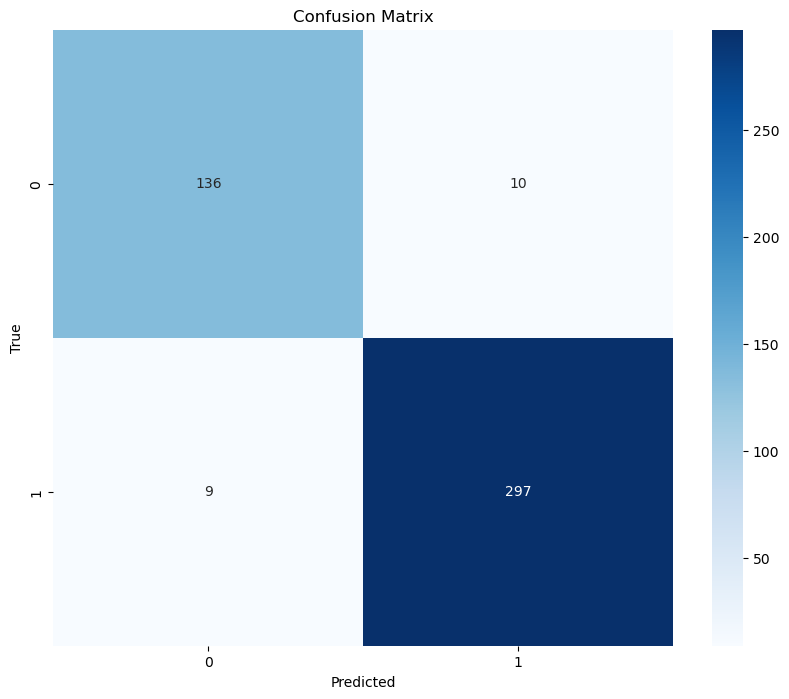

In [3]:
# Load the labeled change events
labelled_coll = load_change_events(labelled_file)
unlabelled_coll = load_change_events(predict_change_events)

# Extract features from the labeled change events
features_df = extract_features(labelled_coll)
features_df = features_df.dropna()
if features_df.empty:
    raise ValueError("No complete data available after dropping missing values.")
features_df_without_id = features_df.drop(columns=['object_id',"event_type"])

#Prepare data for training of Random Forest
X = features_df_without_id.values
y = features_df['event_type'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split, 
                            min_samples_leaf=min_samples_leaf, 
                            max_features=max_features, 
                            bootstrap=bootstrap,
                            random_state=random_state)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [4]:
# Apply the trained model to the unlabelled change events
features_unlabelled_df = extract_features(unlabelled_coll)
features_unlabelled_df = features_unlabelled_df.dropna()
if features_unlabelled_df.empty:
    raise ValueError("No complete data available after dropping missing values.")
features_unlabelled_df_without_id = features_unlabelled_df.drop(columns=["object_id","event_type"])
X_unlabelled = features_unlabelled_df_without_id.values
y_unlabelled_pred = rf.predict(X_unlabelled)
features_unlabelled_df['event_type'] = y_unlabelled_pred

In [6]:
# Create a mapping from object_id to the chosen cluster label (event_type)
label_mapping = dict(zip(features_unlabelled_df['object_id'], features_unlabelled_df['event_type']))

# Update the original events by matching them by object_id.
for event in unlabelled_coll:
    obj_id = event.get('object_id')
    if obj_id in label_mapping:
        event['event_type'] = int(label_mapping[obj_id])
    else:
        # Mark events dropped due to missing features as None
        event['event_type'] = None

# Save the updated events to a new JSON file.
with open(predicted_file, 'w') as f:
    json.dump(unlabelled_coll, f, indent=4)
